# Socio-economic Impact on Green Jobs: An EDA Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import shapiro, spearmanr, kendalltau
import scikit_posthocs as sp
from statsmodels.nonparametric.kernel_regression import KernelReg

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

In [4]:
# Set visual display settings
sns.set(style='whitegrid')

In [5]:
# load csv
original_df = pd.read_csv('complete_renewable_energy_dataset 2.csv')

In [6]:
original_df.head()

,Country,Year,Energy Type,Production (GWh),Installed Capacity (MW),Investments (USD),Population,GDP,Energy Consumption,Energy Exports,...,Economic Freedom Index,Ease of Doing Business,Innovation Index,Number of Research Institutions,Number of Renewable Energy Conferences,Number of Renewable Energy Publications,Energy Sector Workforce,Proportion of Energy from Renewables,Public-Private Partnerships in Energy,Regional Renewable Energy Cooperation
0,USA,2011,Solar,85404.690027,5549.794323,5.604125e+09,1064007213,1.775278e+14,369654.644184,93087.198199,...,49.216800,57.678605,76.803228,851,75,6361,511658,25.907895,1,0
1,Australia,2008,Geothermal,22205.069382,43211.593798,6.361886e+08,1033255852,6.435372e+13,771781.636293,1752.536054,...,79.990942,1.761579,48.697825,590,39,9752,974948,95.003547,0,1
2,Canada,2013,Biomass,94102.732038,6139.117212,6.158680e+09,14895124,1.567926e+14,342707.152899,65146.592498,...,94.374040,77.657334,67.334813,101,7,311,326318,67.354539,1,0
3,Japan,2010,Biomass,88771.932910,40323.639260,8.526116e+09,1448827283,1.350464e+14,498839.574253,50257.591014,...,65.143472,44.987734,4.544289,327,3,7708,506078,33.754104,0,0
4,China,2018,Solar,93288.408581,30755.403056,5.086237e+09,1499494307,8.677956e+13,819064.362785,63101.395562,...,86.213626,62.535223,10.287199,985,69,4919,187964,59.509228,1,0


In [7]:
# Vars

# specify numeric columns
numeric_columns = original_df.select_dtypes(include=['int64', 'float64']).columns

# specify columns to eliminate
columns_to_exclude = ['transaction_id', 'customer_id', 'product_id']

# columns for usual numeric process
cols_to_process = ['GDP', 'Renewable Energy Jobs', 'Innovation Index', 
                      'Industrialization Rate', 'Production (GWh)', 'Educational Level']

num_cols = original_df[cols_to_process].columns.tolist()

# filter out the specified numeric columns
filtered_numeric_columns = [col for col in numeric_columns if col not in columns_to_exclude]


# Create a copy of the original DataFrame
original_df_copy = original_df.copy()

## Data Cleaning

No NAN or duplicate rows detected

### Test For Outliers

In [8]:
def count_outliers_iqr(dataframe, columns):
    outlier_counts = {}
    for column in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Number of outliers
    
    return outlier_counts

# Count outliers in the specified numeric columns
outlier_counts = count_outliers_iqr(original_df, cols_to_process)

print(f"Number of outliers in total_amount column: {outlier_counts}")

Number of outliers in total_amount column: {'GDP': 0, 'Renewable Energy Jobs': 0, 'Innovation Index': 0, 'Industrialization Rate': 0, 'Production (GWh)': 0, 'Educational Level': 0}


## Descriptive Statistics of Selected Indicators

In [9]:
# original
original_df[cols_to_process].describe()

,GDP,Renewable Energy Jobs,Innovation Index,Industrialization Rate,Production (GWh),Educational Level
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.010745e+14,502896.083600,50.280019,49.726759,48743.195073,4.975377
std,5.782363e+13,286748.983941,28.719483,28.687008,28340.915147,2.885123
min,5.603965e+10,1320.000000,0.025733,0.130276,1053.354158,0.000731
25%,5.049265e+13,253688.750000,25.934406,24.940912,24309.656479,2.470056
50%,1.027006e+14,497165.500000,51.398964,49.905989,47367.117600,4.983848
75%,1.519604e+14,754547.000000,74.724073,74.818567,73079.452832,7.474700
max,1.999223e+14,999562.000000,99.998838,99.964557,99937.503719,9.997990


## Linear Regression

Both Regression (Ordinary Least Squares, or OLS) and the Pearson correlation coefficient are used to analyze relationships between variables, but they serve different purposes and provide different insights:

### Pearson Correlation Coefficient
The Pearson correlation coefficient (often denoted as \( r \)) measures the **strength and direction** of the linear relationship between two numeric variables. It ranges from -1 to 1:
- **+1** indicates a perfect positive linear relationship.
- **-1** indicates a perfect negative linear relationship.
- **0** indicates no linear relationship.

**Purpose**:
- **Assessing Linear Relationships**: It helps determine whether and how strongly pairs of variables are linearly related.
- **Direction and Strength**: It provides a single value that indicates both the direction (positive or negative) and the strength of the relationship¹.

### Regression (OLS)
Ordinary Least Squares (OLS) regression is a method for estimating the relationships among variables. It fits a linear equation to observed data:
\[ Y = \beta_0 + \beta_1X + \epsilon \]
where \( Y \) is the dependent variable, \( X \) is the independent variable, \( \beta_0 \) is the intercept, \( \beta_1 \) is the slope, and \( \epsilon \) is the error term.

**Purpose**:
- **Prediction**: It allows for predicting the value of the dependent variable based on the values of the independent variables.
- **Understanding Relationships**: It quantifies the strength and form of the relationship between the dependent and independent variables.
- **Parameter Estimation**: It provides estimates for the coefficients (\( \beta_0 \) and \( \beta_1 \)), which describe the relationship between the variables².

### Key Differences
- **Correlation**: Measures the degree to which two variables move in relation to each other.
- **Regression**: Describes how one variable affects another and can be used for prediction.

### Example
If you have data on hours studied (independent variable) and exam scores (dependent variable):
- **Pearson Correlation**: Tells you how strongly and in what direction hours studied and exam scores are related.
- **Regression**: Provides an equation that predicts exam scores based on hours studied and quantifies how much exam scores are expected to increase for each additional hour studied².

In [10]:
# Define the dependent and independent variables
X = original_df[['GDP', 'Innovation Index','Industrialization Rate', 'Educational Level', 'Production (GWh)']]
y = original_df['Renewable Energy Jobs']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get the residuals
residuals = model.resid

# Print the summary of the regression
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Renewable Energy Jobs   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.006
Method:                    Least Squares   F-statistic:                     3.873
Date:                   Sat, 05 Oct 2024   Prob (F-statistic):            0.00169
Time:                           09:12:52   Log-Likelihood:                -34953.
No. Observations:                   2500   AIC:                         6.992e+04
Df Residuals:                       2494   BIC:                         6.995e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

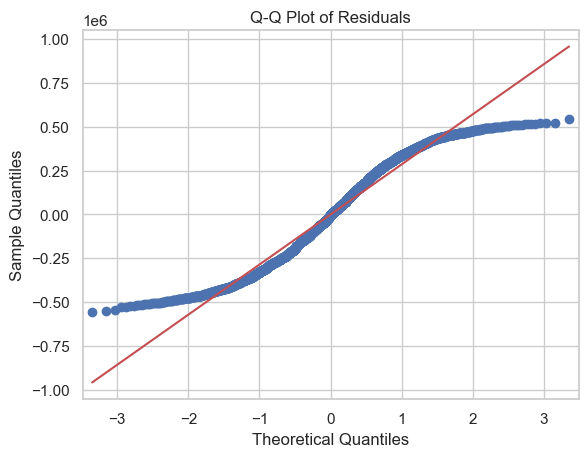

In [11]:
# Plot a Q-Q plot of the Residual
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

### Test the Normality of the Residual

In [12]:
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test[0]}, p-value={shapiro_test[1]}")

Shapiro-Wilk Test: W=0.9593056706211436, p-value=6.5645635257839e-26


You can still use **Ordinary Least Squares (OLS)** regression and **Pearson correlation (Pearson r)** even if your dataset does not follow a normal distribution. However, there are some considerations to keep in mind:

**OLS Regression**

OLS regression assumes that the residuals (errors) of the model are normally distributed, not necessarily the predictors or the response variable. If the residuals are not normally distributed, it can affect the validity of the inference (e.g., confidence intervals and hypothesis tests). Here are some steps you can take:
- Check Residuals: After fitting your OLS model, check the residuals for normality. You can use a Q-Q plot or a Shapiro-Wilk test on the residuals.
- Transformations: If the residuals are not normally distributed, consider transforming your response variable (e.g., log, square root) to achieve normality.
- Robust Regression: If transformations do not help, you might consider using robust regression methods that are less sensitive to deviations from normality.
  
**Pearson Correlation**

Pearson correlation measures the linear relationship between two variables and assumes that both variables are normally distributed. If your data is not normally distributed, the Pearson correlation might not be the best measure. Here are some alternatives:
- Spearman’s Rank Correlation: This is a non-parametric measure that assesses how well the relationship between two variables can be described using a monotonic function. It does not assume normality.
- Kendall’s Tau: Another non-parametric measure that assesses the strength and direction of association between two variables.

__Transforming your variables__ can help address non-normality, but it’s not always necessary to transform both the dependent and independent variables. Here are some guidelines:

When to Transform Variables
**Dependent Variable (Y)**: Transforming the dependent variable can help stabilize variance and make the residuals more normally distributed. Common transformations include log, square root, and Box-Cox transformations.

**Independent Variables (X)**: Transforming independent variables can help linearize relationships and reduce the impact of outliers.

Steps to Decide on Transformations

- Check Residuals: After fitting your model, check the residuals for normality. If the residuals are not normally distributed, consider transforming the dependent variable.
- Assess Relationships: If the relationship between the independent and dependent variables is non-linear, consider transforming the independent variables.
- Experiment: Try different transformations and compare model performance using metrics like R-squared, AIC, or BIC.

In [13]:
## Transform Renewable Energy Jobs column 
# Data Transformation (Square Root Transformation)
original_df_copy['Renewable Energy Jobs'] = np.log(original_df_copy['Renewable Energy Jobs'])

original_df[cols_to_process].head()

,GDP,Renewable Energy Jobs,Innovation Index,Industrialization Rate,Production (GWh),Educational Level
0,1.775278e+14,756878,76.803228,9.518226,85404.690027,5.954401
1,6.435372e+13,945074,48.697825,29.718922,22205.069382,0.759240
2,1.567926e+14,588423,67.334813,10.507145,94102.732038,3.632895
3,1.350464e+14,11049,4.544289,17.599183,88771.932910,4.590746
4,8.677956e+13,225191,10.287199,44.316166,93288.408581,0.001750


In [14]:
# Define the dependent and independent variables
X = original_df[['GDP', 'Innovation Index','Industrialization Rate', 'Educational Level', 'Production (GWh)']]
y = original_df['Renewable Energy Jobs']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get the residuals
residuals = model.resid

# Print the summary of the regression
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Renewable Energy Jobs   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.006
Method:                    Least Squares   F-statistic:                     3.873
Date:                   Sat, 05 Oct 2024   Prob (F-statistic):            0.00169
Time:                           09:12:53   Log-Likelihood:                -34953.
No. Observations:                   2500   AIC:                         6.992e+04
Df Residuals:                       2494   BIC:                         6.995e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [15]:
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test[0]}, p-value={shapiro_test[1]}")

Shapiro-Wilk Test: W=0.9593056706211436, p-value=6.5645635257839e-26


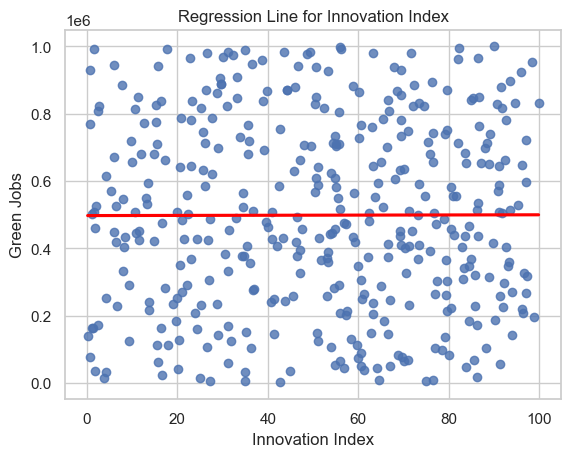

In [16]:
# For Innovation Index (Independent Variables) and Renewable Energy Jobs (Green Jobs) as dependent variable
sampled_df = original_df.sample(n=400) 
# Plotting the regression line for one of the features
sns.regplot(x='Innovation Index', y='Renewable Energy Jobs', data=sampled_df, ci=None, line_kws={"color": "red"})
plt.xlabel('Innovation Index')
plt.ylabel('Green Jobs')
plt.title('Regression Line for Innovation Index')
plt.show()

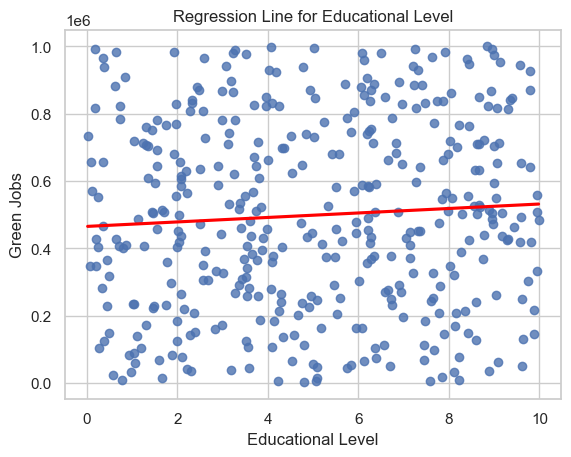

In [17]:
# For Educational Level (Independent Variables) and Renewable Energy Jobs (Green Jobs) as dependent variable
# Plotting the regression line for one of the features
sns.regplot(x='Educational Level', y='Renewable Energy Jobs', data=sampled_df, ci=None, line_kws={"color": "red"})
plt.xlabel('Educational Level')
plt.ylabel('Green Jobs')
plt.title('Regression Line for Educational Level')
plt.show()

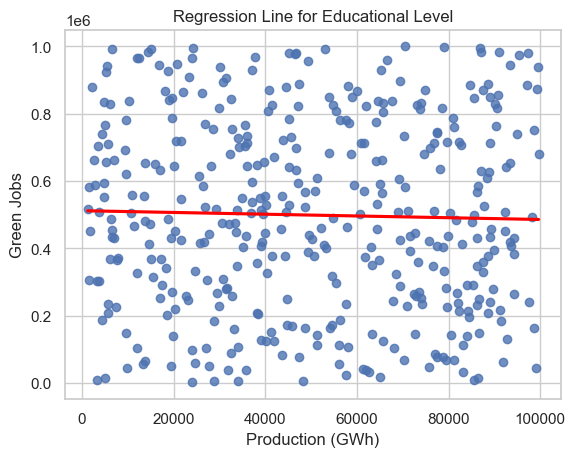

In [18]:
# For Production (Independent Variables) and Renewable Energy Jobs (Green Jobs) as dependent variable
# Plotting the regression line for one of the features
sns.regplot(x='Production (GWh)', y='Renewable Energy Jobs', data=sampled_df, ci=None, line_kws={"color": "red"})
plt.xlabel('Production (GWh)')
plt.ylabel('Green Jobs')
plt.title('Regression Line for Educational Level')
plt.show()

### Non-Parametric Correlation

In [19]:
# Kendall's Tau
independent_vars = original_df[['GDP', 'Innovation Index','Industrialization Rate', 'Educational Level', 'Production (GWh)']]
dependent_var = original_df['Renewable Energy Jobs']

# Initialize a dictionary to store results
results = {}

for column in independent_vars.columns:
    tau, p_value = kendalltau(independent_vars[column], dependent_var)
    results[column] = {f"Kendall's Tau": tau, 'p-value': p_value}

In [20]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)

                        Kendall's Tau   p-value
GDP                          0.023719  0.075461
Innovation Index            -0.031173  0.019473
Industrialization Rate      -0.022987  0.084915
Educational Level           -0.025338  0.057564
Production (GWh)             0.026477  0.047209
